<a href="https://colab.research.google.com/github/yossrlouati/facial-emotion-recognition/blob/main/facial_emotion_recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Data/libriaries**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download  -c challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
replace example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [31]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2 Loding data 

In [11]:
data = pd.read_csv("fer2013/fer2013.csv")
data.shape

(35887, 3)

In [12]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [13]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [14]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

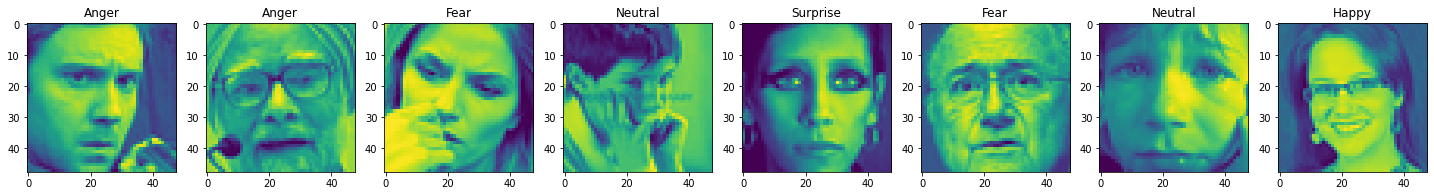

In [15]:
#Showing examples of the images we have in our dataset
h, w = 10, 10        
nrows, ncols = 1, 8  # array of sub-plots
figsize = [20, 30]     # figure size, inches


# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = np.mat(data.pixels[i]).reshape(48, 48) 
    axi.imshow(img)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    axi.set_title(CLASS_LABELS[data.emotion[i]])

plt.tight_layout(True)
plt.show()

# **Data preprocessing**

In [16]:
#Shuffling the data
data = data.sample(frac=1)

In [17]:
#one hot encoding
labels = to_categorical(data[['emotion']], num_classes=7)

In [18]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

In [19]:
#Standardization
pixels = train_pixels.reshape((35887*2304,1))

In [20]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [21]:
#Reshaping the data (48,48)
pixels = train_pixels.reshape((35887, 48, 48,1))

In [22]:
#train test validation split
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


In [24]:
#Data augmentation
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [25]:
datagen.fit(X_train)
valgen.fit(X_val)

In [26]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

# **CNN model**

In [27]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [28]:
model = cnn_model()

In [30]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [32]:
#Adding checkpointer to implement Early Stopping to prevent overfitting.
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.0832 - accuracy: 0.1884
Epoch 1: val_accuracy improved from -inf to 0.24520, saving model to best_model.h5
455/455 [==============================] - 2051s 5s/step - loss: 14.0832 - accuracy: 0.1884 - val_loss: 12.8498 - val_accuracy: 0.2452
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 12.2143 - accuracy: 0.2153
Epoch 2: val_accuracy improved from 0.24520 to 0.25418, saving model to best_model.h5
455/455 [==============================] - 1974s 4s/step - loss: 12.2143 - accuracy: 0.2153 - val_loss: 11.0601 - val_accuracy: 0.2542
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 10.2730 - accuracy: 0.2329
Epoch 3: val_accuracy improved from 0.25418 to 0.27585, saving model to best_model.h5
455/455 [==============================] - 1966s 4s/step - loss: 10.2730 - accuracy: 0.2329 - val_loss: 9.1586 - val_accuracy: 0.2759
Epoch 4/30
198/455 [============>.................

In [ ]:
#Visualizing results
#Loss
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [ ]:
#Accuracy
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [ ]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

In [ ]:
#confusion matrix
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [ ]:
#IMPROVING THE MODEL
#change the epoch number as 50 for the cnn_mode
model = cnn_model()
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)



In [ ]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

In [ ]:
#confusion matrix
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3)

The model trained with 50 epochs has better results than the model trained with 30 epochs.